# 🧠 Clasificación de la Enfermedad de Alzheimer
Integrantes
- Diego Alexander Hernández Silvestre - 21270
- Linda Inés Jiménez Vides - 21169
- Mario Antonio Guerra Morales - 21008
- Kristopher Javier Alvarado López - 21188

In [2]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import random
import shutil
import shap
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

c:\Users\lijv1.LINDA_HP\Documents\GitHub\Classification_of_Alzheimers_Disease\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 📊 Balanceo de Data

In [ ]:
# Definir las transformaciones que aplicarás
augmentations = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Rotación de ±10 grados
    transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)),  # Desplazamiento horizontal/vertical 2%
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.92, 1.08)),  # Zoom hasta 8%
    transforms.ToTensor(),
])

# Clase personalizada para cargar imágenes desde carpetas
class DementiaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_list = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Directorios de las carpetas de imágenes
folders = {
    "MildDemented": "data/train/MildDemented",
    "ModerateDemented": "data/train/ModerateDemented",
    "NonDemented": "data/train/NonDemented",
    "VeryMildDemented": "data/train/VeryMildDemented"
}

# Directorios donde se guardarán las imágenes aumentadas
augmented_folders = {
    "MildDemented": "data/augmented/MildDemented",
    "ModerateDemented": "data/augmented/ModerateDemented",
    "NonDemented": "data/augmented/NonDemented",
    "VeryMildDemented": "data/augmented/VeryMildDemented"
}

target_size = 3200  # Número objetivo de imágenes por clase

# Crear los directorios para las imágenes aumentadas si no existen
for folder in augmented_folders.values():
    if not os.path.exists(folder):
        os.makedirs(folder)

# Función para aplicar augmentación y guardar nuevas imágenes
def augment_and_save(dataset, save_dir, target_size):
    current_size = len(dataset)
    images_to_generate = target_size  # Calcular cuántas imágenes generar para llegar a 3200
    counter = 0  # Contador para las nuevas imágenes aumentadas
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Generar imágenes hasta alcanzar el tamaño objetivo
    while counter < images_to_generate:
        for batch in loader:
            augmented_img = transforms.ToPILImage()(batch[0])  # Convertir tensor a imagen PIL
            augmented_img.save(os.path.join(save_dir, f'augmented_{counter + current_size}.jpg'))  # Guardar imagen aumentada
            counter += 1
            if counter >= images_to_generate:
                break

# Iterar sobre cada carpeta de imágenes originales
for label, folder in folders.items():
    current_images = os.listdir(folder)
    current_size = len(current_images)
        
    # Si el tamaño actual es menor a 3200, se realiza augmentación
    if current_size < target_size:
        print(f"Aplicando augmentación en {label}. Tamaño actual: {current_size}.")
        
        # Cargar el dataset de la clase actual
        dataset = DementiaDataset(image_dir=folder, transform=augmentations)
        
        # Definir el directorio para guardar imágenes aumentadas
        save_dir = augmented_folders[label]
        
        # Aumentar imágenes y guardar en la carpeta de imágenes aumentadas
        augment_and_save(dataset, save_dir, target_size)
        
    else:
        print(f"No se necesita augmentación en {label}. Tamaño actual: {current_size}.")


Aplicando augmentación en MildDemented. Tamaño actual: 717.
Aplicando augmentación en ModerateDemented. Tamaño actual: 52.
Aplicando augmentación en NonDemented. Tamaño actual: 2560.
Aplicando augmentación en VeryMildDemented. Tamaño actual: 1792.


In [42]:
for label, folder in augmented_folders.items():
    current_images = os.listdir(folder)
    current_size = len(current_images)
    print(f"Clase: {label}. Tamaño actual: {current_size}.")

Clase: MildDemented. Tamaño actual: 3200.
Clase: ModerateDemented. Tamaño actual: 3200.
Clase: NonDemented. Tamaño actual: 3200.
Clase: VeryMildDemented. Tamaño actual: 3200.


#### 🏋🏽‍♀️ División entrenamiento y validación

In [43]:
# Directorios donde se guardarán las imágenes divididas
train_folder = "data/augmented/"

train_dir = "new_data/train/"
val_dir = "new_data/validation/"

# Crear los directorios de train y validation si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Contadores para el total de imágenes en train y validation
total_train_images = 0
total_val_images = 0

# Función para dividir y copiar las imágenes de train en train/validation
def split_train_validation(train_folder, label, train_dir, val_dir, split_ratio=0.7):
    global total_train_images, total_val_images
    images = os.listdir(os.path.join(train_folder, label))
    random.shuffle(images)
    
    # Calcular cuántas imágenes irán a train y cuántas a validation
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]
    
    # Actualizar los contadores
    total_train_images += len(train_images)
    total_val_images += len(val_images)
    
    # Crear carpetas de train y validation para la clase actual
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    
    # Copiar imágenes de train
    for img in train_images:
        shutil.copy(os.path.join(train_folder, label, img), os.path.join(train_dir, label, img))
    
    # Copiar imágenes de validation
    for img in val_images:
        shutil.copy(os.path.join(train_folder, label, img), os.path.join(val_dir, label, img))

# Iterar sobre las carpetas de cada clase dentro de train
for label in os.listdir(train_folder):
    split_train_validation(train_folder, label, train_dir, val_dir, split_ratio=0.7)

# Imprimir el total de imágenes en train y validation
print(f"Total de imágenes en train: {total_train_images}")
print(f"Total de imágenes en validation: {total_val_images}")
print("División de imágenes de train en train/validation completada.")

Total de imágenes en train: 8960
Total de imágenes en validation: 3840
División de imágenes de train en train/validation completada.


In [5]:
def process_images(image_path, target_size=(224, 224)):
    """
    Procesa una imagen para convertirla al formato deseado:
    - Convierte a escala de grises
    - Normaliza los valores
    - Añade dimensión de canal
    """
    # Leer la imagen
    if isinstance(image_path, str):
        img = cv2.imread(image_path)
        if img is None:
            return None
    else:
        img = image_path
    
    # Convertir a escala de grises si la imagen es a color
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img = cv2.resize(img, target_size)
    
    # Normalizar valores a [0,1]
    img = img.astype('float32') / 255.0
    
    # Añadir dimensión de canal (32, 32) -> (32, 32, 1)
    img = np.expand_dims(img, axis=-1)
    
    return img

def prepare_dataset(train_folder, target_size=(224, 224)):
    """
    Prepara el dataset completo en el formato deseado
    """
    x_train = []
    y_train = []
    
    # Obtener lista de clases (carpetas)
    classes = sorted(os.listdir(train_folder))
    
    # Procesar cada clase
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(train_folder, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # Procesar cada imagen en la clase
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            processed_img = process_images(img_path, target_size)
            
            if processed_img is not None:
                x_train.append(processed_img)
                y_train.append(class_idx)
    
    # Convertir a arrays de numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    return x_train, y_train

def split_dataset(x_data, y_data, train_ratio=0.7):
    """
    Divide el dataset en entrenamiento y prueba
    """
    # Crear índices y mezclarlos
    indices = np.arange(len(x_data))
    np.random.shuffle(indices)
    
    # Calcular punto de división
    split_idx = int(len(indices) * train_ratio)
    
    # Dividir datos
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    x_train = x_data[train_indices]
    y_train = y_data[train_indices]
    x_test = x_data[test_indices]
    y_test = y_data[test_indices]
    
    return x_train, x_test, y_train, y_test

# Uso del código
if __name__ == "__main__":
    # Directorios
    train_folder = "data/augmented/"
    
    # Preparar dataset
    print("Procesando imágenes...")
    x_data, y_data = prepare_dataset(train_folder)
    
    # Dividir dataset
    print("Dividiendo dataset...")
    x_train, x_test, y_train, y_test = split_dataset(x_data, y_data)
    
    # Imprimir formas de los arrays
    print("\nFormas de los arrays:")
    print(f"x_train: {x_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # También puedes guardar los arrays procesados
    np.save('x_train.npy', x_train)
    np.save('x_test.npy', x_test)
    np.save('y_train.npy', y_train)
    np.save('y_test.npy', y_test)

Procesando imágenes...
Dividiendo dataset...

Formas de los arrays:
x_train: (8960, 224, 224, 1)
x_test: (3840, 224, 224, 1)
y_train: (8960,)
y_test: (3840,)


#### Arquitectura del Modelo

In [51]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformaciones (Aumento de datos y normalización)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar las imágenes
    transforms.RandomHorizontalFlip(),  # Voltear horizontalmente
    transforms.RandomRotation(10),  # Rotar aleatoriamente hasta 10 grados
    transforms.ToTensor(),  # Convertir a tensor (esto convierte automáticamente a float y escala a [0, 1])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización estándar
])

In [52]:
# Cargar los datasets de entrenamiento y validación
train_data = datasets.ImageFolder('new_data/train', transform=transform)
val_data = datasets.ImageFolder('new_data/validation', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [53]:
# Definición del modelo CNN basado en la arquitectura del artículo
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Entrada 224x224x3 -> Salida 224x224x32
        self.pool = nn.MaxPool2d(2, 2)  # Reduce 2x cada dimensión: 112x112x32 después de la 1ra convolución
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Entrada 112x112x32 -> Salida 112x112x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Entrada 56x56x64 -> Salida 56x56x128
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Capa totalmente conectada, entrada 128*28*28 = 100352, salida 512
        self.fc2 = nn.Linear(512, 4)  # Capa de salida, 4 clases para la clasificación
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + MaxPool
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 + MaxPool
        x = x.view(-1, 128 * 28 * 28)  # Aplanar para la capa totalmente conectada
        x = F.relu(self.fc1(x))  # FC1
        x = self.dropout(x)  # Dropout
        x = self.fc2(x)  # FC2 - Salida final
        return x

#### Entrenamiento del Modelo

In [54]:
# Inicializar el modelo
model = CNNModel().to(device)

# Usar CrossEntropyLoss, que combina softmax y entropía cruzada
criterion = nn.CrossEntropyLoss()

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Entrenamiento del modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Empieza el entrenamiento para la época {epoch+1} \n")
        model.train()  # Modo de entrenamiento
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar gradientes previos
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Calcular gradientes
            optimizer.step()  # Actualizar pesos

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print("Pérdida por época calculada.\n")

        # Validación
        model.eval()  # Modo de evaluación (sin actualización de gradientes)
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        print("Pérdida por validación calculada.\n")
        val_loss = val_loss / len(val_loader.dataset)
        accuracy = correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}')

    print('Entrenamiento completo.')

In [55]:
# Entrenar el modelo
train_model(model, train_loader, val_loader, criterion, optimizer)

# Guardar el modelo
torch.save(model.state_dict(), 'model.pth')

Empieza el entrenamiento para la época 1 

Pérdida por época calculada.

Pérdida por validación calculada.

Epoch [1/10], Loss: 1.1148, Val Loss: 0.8712, Val Accuracy: 0.6067
Empieza el entrenamiento para la época 2 

Pérdida por época calculada.

Pérdida por validación calculada.

Epoch [2/10], Loss: 0.7355, Val Loss: 0.6372, Val Accuracy: 0.6968
Empieza el entrenamiento para la época 3 

Pérdida por época calculada.

Pérdida por validación calculada.

Epoch [3/10], Loss: 0.6292, Val Loss: 0.5760, Val Accuracy: 0.7404
Empieza el entrenamiento para la época 4 

Pérdida por época calculada.

Pérdida por validación calculada.

Epoch [4/10], Loss: 0.5657, Val Loss: 0.5254, Val Accuracy: 0.7592
Empieza el entrenamiento para la época 5 

Pérdida por época calculada.

Pérdida por validación calculada.

Epoch [5/10], Loss: 0.5248, Val Loss: 0.4931, Val Accuracy: 0.7813
Empieza el entrenamiento para la época 6 

Pérdida por época calculada.

Pérdida por validación calculada.

Epoch [6/10], Los

In [56]:
# Evaluar el modelo en los datos de validación
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    print(f'Precisión en el conjunto de validación: {accuracy * 100:.2f}%')

# Crear una instancia del modelo y cargar el estado guardado
model = CNNModel().to(device)
model.load_state_dict(torch.load('model.pth'))

# Evaluar el modelo
evaluate_model(model, val_loader)

C:\Users\lijv1.LINDA_HP\AppData\Local\Temp\ipykernel_23456\1126260831.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


Precisión en el conjunto de validación: 85.62%


### Modelo Tensorflow

In [ ]:
# Definición del modelo en TensorFlow basado en el modelo de PyTorch
inputs = Input(shape=(224, 224, 1), name="Input")
x = Conv2D(32, 3, activation="relu", padding='same', name='Conv1')(inputs)  # Conv1
x = MaxPooling2D(2, name='Pool1')(x)  # MaxPool después de Conv1

x = Conv2D(64, 3, activation="relu", padding='same', name='Conv2')(x)  # Conv2
x = MaxPooling2D(2, name='Pool2')(x)  # MaxPool después de Conv2

x = Conv2D(128, 3, activation="relu", padding='same', name='Conv3')(x)  # Conv3
x = MaxPooling2D(2, name='Pool3')(x)  # MaxPool después de Conv3

# Aplanar la salida para conectarla a la capa totalmente conectada
x = Flatten(name='Flatten')(x)
x = Dense(512, activation="relu", name='FC1')(x)  # FC1
x = Dropout(0.5, name='Dropout')(x)  # Dropout después de FC1

# Capa de salida
outputs = Dense(4, activation="softmax", name='Output')(x)

# Crear el modelo
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,475,460 (196.36 MB)

 Trainable params: 51,475,460 (196.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_train))

print(num_classes)

hist = model.fit(
	x_train,
	to_categorical(y_train, num_classes),  # One-hot encode your labels
	batch_size=32,
	epochs=10,
	validation_split=0.15,
	shuffle='on')

model.save('modelo_tf.h5')
# One-hot encode y_test labels
y_test_one_hot = to_categorical(y_test, num_classes)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(x_test, y_test_one_hot)
print(f"Loss: {loss}, Accuracy: {accuracy}")


4
Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 173s 713ms/step - acc: 0.3264 - loss: 1.4143 - val_acc: 0.6339 - val_loss: 0.8133
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 165s 695ms/step - acc: 0.6463 - loss: 0.7877 - val_acc: 0.6987 - val_loss: 0.6478
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 165s 692ms/step - acc: 0.7432 - loss: 0.5971 - val_acc: 0.7225 - val_loss: 0.5730
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 166s 696ms/step - acc: 0.7853 - loss: 0.4935 - val_acc: 0.7612 - val_loss: 0.5238
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 167s 701ms/step - acc: 0.8391 - loss: 0.3855 - val_acc: 0.7708 - val_loss: 0.5174
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 164s 687ms/step - acc: 0.8772 - loss: 0.2998 - val_acc: 0.7805 - val_loss: 0.5236
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 164s 690ms/step - acc: 0.9048 - loss: 0.2270 - val_acc: 0.8147 - val_loss: 0.4687
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 164s 689ms/step - acc: 0.9360 - loss: 0.1698 - val_acc: 0.8103 - val_loss: 0.4920
Epoch 9/10
238/238 ━━━

In [74]:
y_hat=model.predict(x_test) #test the model, prob.


120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step


In [77]:
print('Acc=',np.sum(y_hat.argmax(1)==y_test)/y_test.shape[0])
labels = list(os.listdir('new_data/train'))
labels

Acc= 0.84453125


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [7]:
model = tf.keras.models.load_model('modelo_tf.h5')
labels = list(os.listdir('data/augmented'))

### SHAP Values

PartitionExplainer explainer: 2it [00:44, 44.46s/it]               


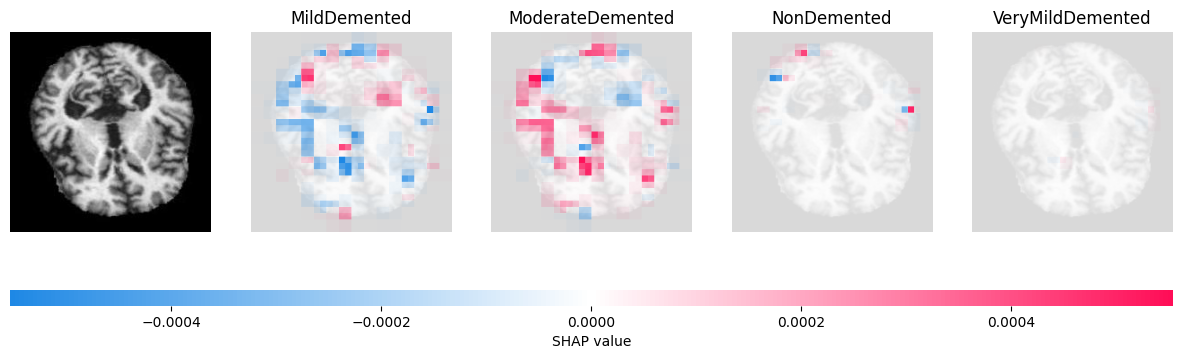

PartitionExplainer explainer: 2it [00:42, 42.90s/it]               


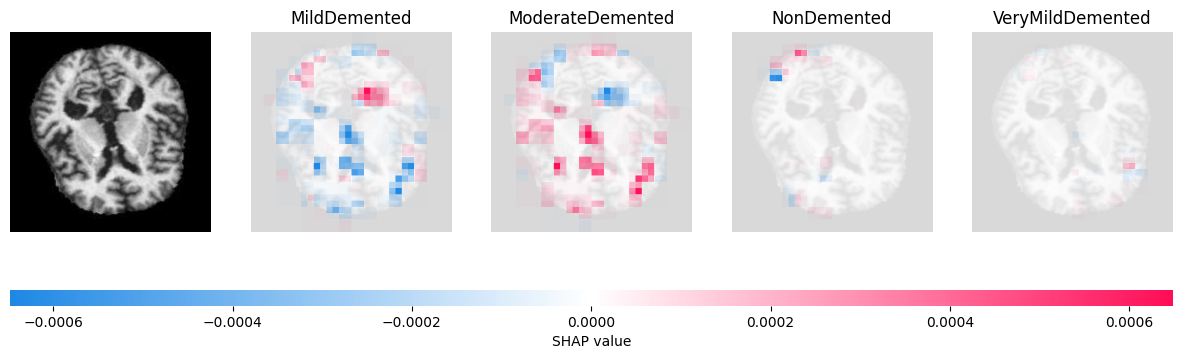

In [16]:
def f(x):
    tmp = x.copy()
    return model(tmp)
import numpy as np

def blur_mask(image, kernel_size=32):
    blurred_image = np.zeros_like(image)
    for i in range(0, image.shape[0], kernel_size):
        for j in range(0, image.shape[1], kernel_size):
            # Obtener el bloque y calcular el promedio
            block = image[i:i+kernel_size, j:j+kernel_size]
            mean_value = block.mean(axis=(0, 1))
            blurred_image[i:i+kernel_size, j:j+kernel_size] = mean_value
    return blurred_image

masker_blur = shap.maskers.Image(blur_mask(x_test[0]), x_test[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(4)))


ind=[1350]
shap_values_ = explainer( x_test[ind], max_evals=5000, batch_size=50 )     
shap.image_plot(shap_values_,labels=labels)

ind=[3800]
shap_values_ = explainer( x_test[ind], max_evals=5000, batch_size=50 )     
shap.image_plot(shap_values_,labels=labels)

c:\Users\lijv1.LINDA_HP\Documents\GitHub\Classification_of_Alzheimers_Disease\.venv\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\lijv1.LINDA_HP\Documents\GitHub\Classification_of_Alzheimers_Disease\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: Input. Received: the structure of inputs=['*']
  warnings.warn(


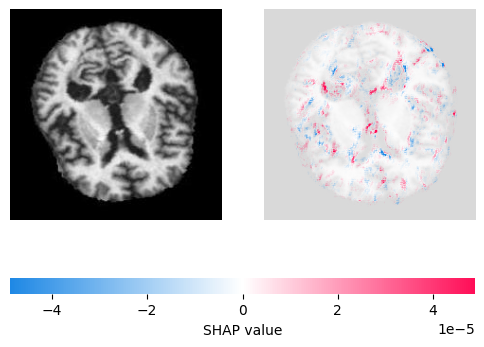

In [14]:
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
e = shap.DeepExplainer(model, background)
ind=[3800]
shap_values = e.shap_values( x_test[ind])
shap.image_plot(shap_values,x_test[ind])

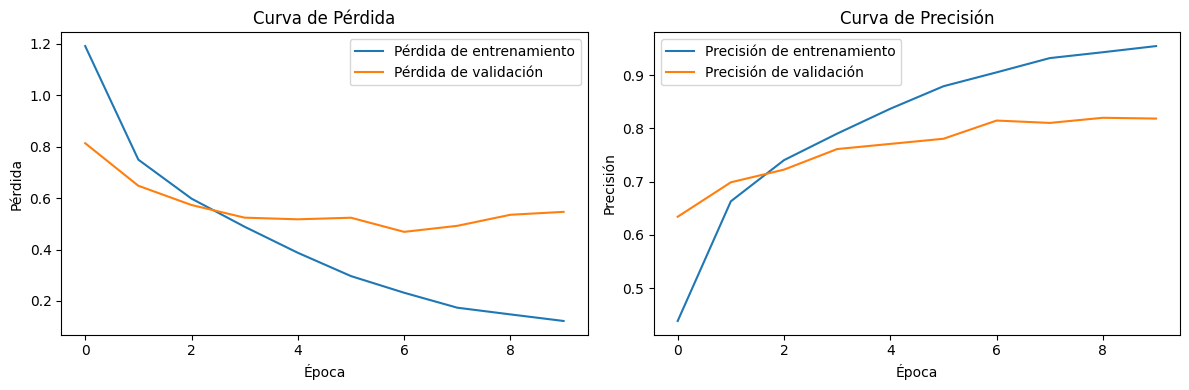

In [ ]:
import matplotlib.pyplot as plt

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(12, 4))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Pérdida de entrenamiento')
plt.plot(hist.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la precisión
plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], label='Precisión de entrenamiento')
plt.plot(hist.history['val_acc'], label='Precisión de validación')
plt.title('Curva de Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Resnet50

In [40]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1. Build the ResNet50-based model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(4, activation='softmax')(x)
model = Model(inputs, outputs)

# Configurar SGD con momentum
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 2. Prepare data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/augmented',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'data/augmented',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# 3. Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

model.save('resnet_model_TF.h5')

# 4. Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 10240 images belonging to 4 classes.
Found 2560 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


c:\Users\Alvar\OneDrive\Documentos\SemestreVIII\Deep Learning\Classification_of_Alzheimers_Disease\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.2538 - loss: 5.6749 - val_accuracy: 0.2500 - val_loss: 5.6187
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.2905 - loss: 4.8636 - val_accuracy: 0.3637 - val_loss: 2.7075
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.2901 - loss: 4.5779 - val_accuracy: 0.2605 - val_loss: 6.0342
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - accuracy: 0.3022 - loss: 4.1838 - val_accuracy: 0.2648 - val_loss: 4.0239
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.3031 - loss: 4.4380 - val_accuracy: 0.2516 - val_loss: 4.9276
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.3026 - loss: 4.4788 - val_accuracy: 0.2500 - val_loss: 6.1253
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.3065 - loss: 4.4560 - val_accuracy: 0.2504 - val_loss: 5.9809
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.3272 - loss: 4.0142 - val_accu

40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 834ms/step - accuracy: 0.3626 - loss: 1.6208
Test Loss: 1.6671499013900757, Test Accuracy: 0.3275996744632721


In [2]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('resnet_model_TF.h5')


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2. Prepare data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    'data/augmented',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'data/augmented',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 10240 images belonging to 4 classes.
Found 2560 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [7]:
# Evaluar el modelo cargado
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

c:\Users\Alvar\OneDrive\Documentos\SemestreVIII\Deep Learning\Classification_of_Alzheimers_Disease\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 855ms/step - accuracy: 0.3626 - loss: 1.6208
Test Loss: 1.6671499013900757, Test Accuracy: 0.3275996744632721


In [ ]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def blur_mask(image, kernel_size=32):
    blurred_image = np.zeros_like(image)
    for i in range(0, image.shape[0], kernel_size):
        for j in range(0, image.shape[1], kernel_size):
            block = image[i:i+kernel_size, j:j+kernel_size]
            mean_value = block.mean(axis=(0, 1))
            blurred_image[i:i+kernel_size, j:j+kernel_size] = mean_value
    return blurred_image

# 2. Definimos la función de predicción
def f(x):
    if len(x.shape) == 3:
        x = np.expand_dims(x, axis=0)
    return model.predict(x, verbose=0)


# 3. Obtenemos algunas imágenes de test para analizar
# Obtenemos un batch completo
test_batch = next(test_generator)
x_test_sample = test_batch[0]
y_test_sample = test_batch[1]

# 4. Creamos el explainer
print("Configurando el explainer...")
masker_blur = shap.maskers.Image(blur_mask(x_test_sample[0]), x_test_sample[0].shape)

# Obtener las etiquetas de las clases del generador
class_labels = list(test_generator.class_indices.keys())

explainer = shap.Explainer(f, 
                          masker_blur, 
                          output_names=class_labels)

Configurando el explainer...


Generando visualizaciones para cada clase...


PartitionExplainer explainer: 2it [02:37, 157.79s/it]              

Forma de shap_values para la clase 'MildDemented': (1, 224, 224, 3)
Llamando a shap.image_plot para la clase 'MildDemented'...


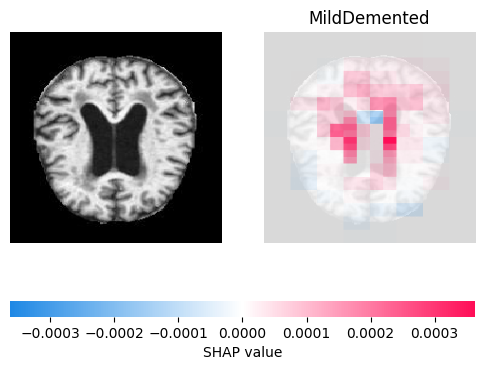

Forma de shap_values para la clase 'ModerateDemented': (1, 224, 224, 3)
Llamando a shap.image_plot para la clase 'ModerateDemented'...


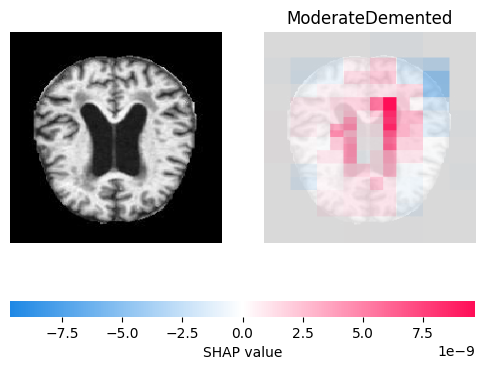

Forma de shap_values para la clase 'NonDemented': (1, 224, 224, 3)
Llamando a shap.image_plot para la clase 'NonDemented'...


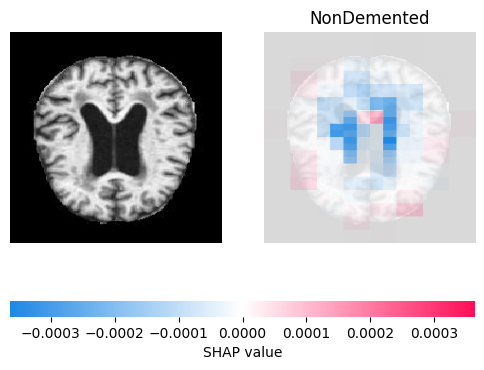

Forma de shap_values para la clase 'VeryMildDemented': (1, 224, 224, 3)
Llamando a shap.image_plot para la clase 'VeryMildDemented'...


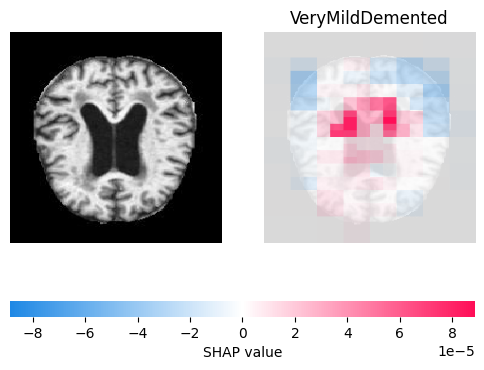

In [33]:
# 6. Visualizamos los resultados para cada clase
print("Generando visualizaciones para cada clase...")

# Genera los valores SHAP
shap_values = explainer(x_test_sample[ind], max_evals=5000, batch_size=50)

# Recorre todas las clases y genera una visualización por clase
for class_index in range(4):
    # Selecciona la etiqueta de la clase actual
    class_label = class_labels[class_index]
    
    # Extrae los valores SHAP para la clase actual
    shap_values_for_class = shap_values.values[..., class_index]
    
    # Verificación de la forma de los valores SHAP seleccionados
    print(f"Forma de shap_values para la clase '{class_label}':", shap_values_for_class.shape)
    
    # Llamada a shap.image_plot para la clase actual
    print(f"Llamando a shap.image_plot para la clase '{class_label}'...")
    shap.image_plot([shap_values_for_class], x_test_sample[ind], labels=[class_label])


# MobileNetV2

In [70]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del modelo MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce la dimensionalidad
x = Dense(64, activation="relu")(x)  # Capa completamente conectada
output = Dense(4, activation="softmax")(x)  # Capa de salida para 4 clases

# Definición del modelo final
model = Model(inputs=base_model.input, outputs=output)

# Congelar las capas del modelo base para acelerar el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Compilación del modelo con SGD
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Imprimir la arquitectura del modelo
model.summary()

# Generadores de datos con la configuración proporcionada
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/augmented',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'data/augmented',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Definir Early Stopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

# Evaluación final en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%")

# Guardar el modelo entrenado
model.save('model_mobilenetv2.h5')
print("Modelo guardado como 'model_mobilenetv2.h5'")


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_22[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,228 (8.93 MB)

 Trainable params: 82,244 (321.27 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Found 10240 images belonging to 4 classes.
Found 2560 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 187s 288ms/step - accuracy: 0.4495 - loss: 1.2149 - val_accuracy: 0.5781 - val_loss: 0.9356
Epoch 2/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 183s 286ms/step - accuracy: 0.6114 - loss: 0.8834 - val_accuracy: 0.6566 - val_loss: 0.7843
Epoch 4/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 185s 290ms/step - accuracy: 0.6486 - loss: 0.7890 - val_accuracy: 0.6766 - val_loss: 0.7485
Epoch 6/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 183s 285ms/step - accuracy: 0.6647 - loss: 0.7523 - val_accuracy: 0.6754 - val_loss: 0.7258
Epoch 8/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accu

Precisión en el conjunto de prueba: 52.23%
Modelo guardado como 'model_mobilenetv2.h5'


# CNN Normal con SGD Optimizer

In [56]:
import cv2


def process_images(image_path, target_size=(224, 224)):
    """
    Procesa una imagen para convertirla al formato deseado:
    - Convierte a escala de grises
    - Normaliza los valores
    - Añade dimensión de canal
    """
    # Leer la imagen
    if isinstance(image_path, str):
        img = cv2.imread(image_path)
        if img is None:
            return None
    else:
        img = image_path
    
    # Convertir a escala de grises si la imagen es a color
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img = cv2.resize(img, target_size)
    
    # Normalizar valores a [0,1]
    img = img.astype('float32') / 255.0
    
    # Añadir dimensión de canal (32, 32) -> (32, 32, 1)
    img = np.expand_dims(img, axis=-1)
    
    return img

def prepare_dataset(train_folder, target_size=(224, 224)):
    """
    Prepara el dataset completo en el formato deseado
    """
    x_train = []
    y_train = []
    
    # Obtener lista de clases (carpetas)
    classes = sorted(os.listdir(train_folder))
    
    # Procesar cada clase
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(train_folder, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # Procesar cada imagen en la clase
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            processed_img = process_images(img_path, target_size)
            
            if processed_img is not None:
                x_train.append(processed_img)
                y_train.append(class_idx)
    
    # Convertir a arrays de numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    return x_train, y_train

def split_dataset(x_data, y_data, train_ratio=0.7):
    """
    Divide el dataset en entrenamiento y prueba
    """
    # Crear índices y mezclarlos
    indices = np.arange(len(x_data))
    np.random.shuffle(indices)
    
    # Calcular punto de división
    split_idx = int(len(indices) * train_ratio)
    
    # Dividir datos
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    x_train = x_data[train_indices]
    y_train = y_data[train_indices]
    x_test = x_data[test_indices]
    y_test = y_data[test_indices]
    
    return x_train, x_test, y_train, y_test

# Uso del código
if __name__ == "__main__":
    # Directorios
    train_folder = "data/augmented/"
    
    # Preparar dataset
    print("Procesando imágenes...")
    x_data, y_data = prepare_dataset(train_folder)
    
    # Dividir dataset
    print("Dividiendo dataset...")
    x_train, x_test, y_train, y_test = split_dataset(x_data, y_data)
    
    # Imprimir formas de los arrays
    print("\nFormas de los arrays:")
    print(f"x_train: {x_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # También puedes guardar los arrays procesados
    np.save('x_train.npy', x_train)
    np.save('x_test.npy', x_test)
    np.save('y_train.npy', y_train)
    np.save('y_test.npy', y_test)

Procesando imágenes...
Dividiendo dataset...

Formas de los arrays:
x_train: (8960, 224, 224, 1)
x_test: (3840, 224, 224, 1)
y_train: (8960,)
y_test: (3840,)


In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

# Definición del modelo en TensorFlow usando SGD como optimizador
inputs = Input(shape=(224, 224, 1), name="Input")
x = Conv2D(32, 3, activation="relu", padding='same', name='Conv1')(inputs)  # Conv1
x = MaxPooling2D(2, name='Pool1')(x)  # MaxPool después de Conv1

x = Conv2D(64, 3, activation="relu", padding='same', name='Conv2')(x)  # Conv2
x = MaxPooling2D(2, name='Pool2')(x)  # MaxPool después de Conv2

x = Conv2D(128, 3, activation="relu", padding='same', name='Conv3')(x)  # Conv3
x = MaxPooling2D(2, name='Pool3')(x)  # MaxPool después de Conv3

# Aplanar la salida para conectarla a la capa totalmente conectada
x = Flatten(name='Flatten')(x)
x = Dense(512, activation="relu", name='FC1')(x)  # FC1
x = Dropout(0.5, name='Dropout')(x)  # Dropout después de FC1

# Capa de salida
outputs = Dense(4, activation="softmax", name='Output')(x)

# Crear el modelo
model_sgd = Model(inputs, outputs)

# Compilar el modelo con SGD en lugar de Adam
model_sgd.compile(optimizer=SGD(learning_rate=0.01), loss=CategoricalCrossentropy(), metrics=['acc'])

# Mostrar la arquitectura del modelo
model_sgd.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,475,460 (196.36 MB)

 Trainable params: 51,475,460 (196.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,475,460 (196.36 MB)

 Trainable params: 51,475,460 (196.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 118s 470ms/step - acc: 0.2661 - loss: 1.3860 - val_acc: 0.4018 - val_loss: 1.3596
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 111s 465ms/step - acc: 0.3423 - loss: 1.3509 - val_acc: 0.4658 - val_loss: 1.2271
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 117s 491ms/step - acc: 0.4440 - loss: 1.2316 - val_acc: 0.5737 - val_loss: 1.0430
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 111s 466ms/step - acc: 0.5237 - loss: 1.0795 - val_acc: 0.5900 - val_loss: 0.9007
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 110s 461ms/step - acc: 0.5869 - loss: 0.9196 - val_acc: 0.6057 - val_loss: 0.8209
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 110s 462ms/step - acc: 0.6277 - loss: 0.8222 - val_acc: 0.6592 - val_loss: 0.7710
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 110s 463ms/step - acc: 0.6648 - loss: 0.7383 - val_acc: 0.6592 - val_loss: 0.7163
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 111s 467ms/step - acc: 0.6773 - loss: 0.7053 - val_acc: 0.6696 - val_loss: 0.6902
Epoch 9/10
238/238 ━━━━━

120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - acc: 0.7290 - loss: 0.6245
Loss: 0.6338285803794861, Accuracy: 0.7158854007720947


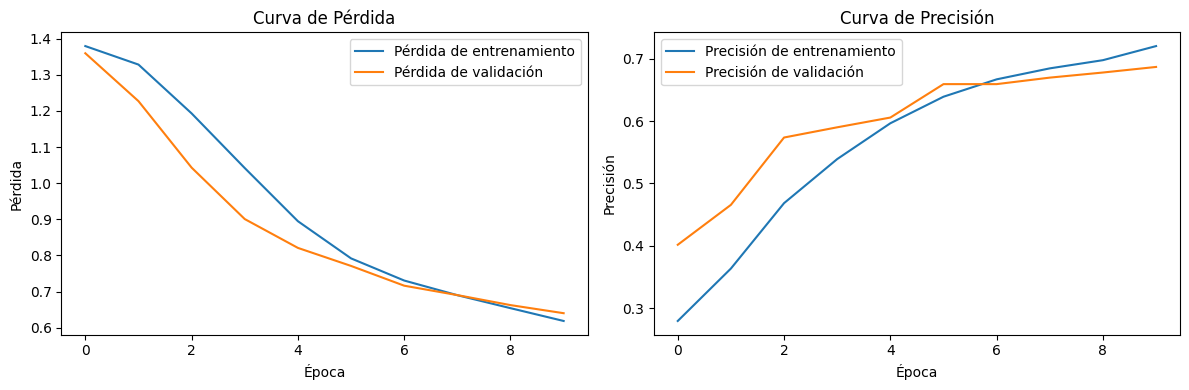

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Preparar las etiquetas de entrenamiento y prueba en formato one-hot
num_classes = 4
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Paso 2: Definir el modelo de red neuronal con SGD como optimizador
inputs = Input(shape=(224, 224, 1), name="Input")
x = Conv2D(32, 3, activation="relu", padding='same', name='Conv1')(inputs)  # Conv1
x = MaxPooling2D(2, name='Pool1')(x)  # MaxPool después de Conv1

x = Conv2D(64, 3, activation="relu", padding='same', name='Conv2')(x)  # Conv2
x = MaxPooling2D(2, name='Pool2')(x)  # MaxPool después de Conv2

x = Conv2D(128, 3, activation="relu", padding='same', name='Conv3')(x)  # Conv3
x = MaxPooling2D(2, name='Pool3')(x)  # MaxPool después de Conv3

# Aplanar la salida para conectarla a la capa totalmente conectada
x = Flatten(name='Flatten')(x)
x = Dense(512, activation="relu", name='FC1')(x)  # FC1
x = Dropout(0.5, name='Dropout')(x)  # Dropout después de FC1

# Capa de salida
outputs = Dense(num_classes, activation="softmax", name='Output')(x)

# Crear el modelo
model_sgd = Model(inputs, outputs)

# Compilar el modelo con SGD como optimizador
model_sgd.compile(optimizer=SGD(learning_rate=0.01), loss=CategoricalCrossentropy(), metrics=['acc'])

# Mostrar la arquitectura del modelo
model_sgd.summary()

# Paso 3: Entrenar el modelo
hist = model_sgd.fit(
    x_train,                    # Datos de entrenamiento
    y_train_one_hot,            # Etiquetas one-hot de entrenamiento
    batch_size=32,              # Tamaño del lote, ajusta según tus recursos
    epochs=10,                  # Número de épocas
    validation_split=0.15,      # Porcentaje de datos para validación
    shuffle=True                # Mezclar datos en cada época
)

# Paso 4: Guardar el modelo
model_sgd.save('modelo_sgd.h5')

# Paso 5: Evaluar el modelo en el conjunto de prueba
loss, accuracy = model_sgd.evaluate(x_test, y_test_one_hot)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Paso 6: Visualizar los resultados de entrenamiento y validación
# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(12, 4))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Pérdida de entrenamiento')
plt.plot(hist.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la precisión
plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], label='Precisión de entrenamiento')
plt.plot(hist.history['val_acc'], label='Precisión de validación')
plt.title('Curva de Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


Generando valores SHAP para el índice 610...


PartitionExplainer explainer: 2it [00:32, 32.68s/it]               


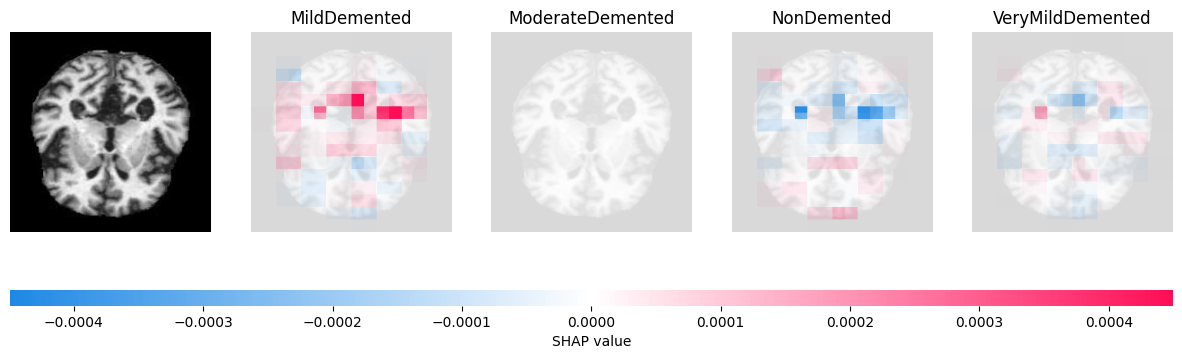

Generando valores SHAP para el índice 601...


PartitionExplainer explainer: 2it [00:30, 30.72s/it]               


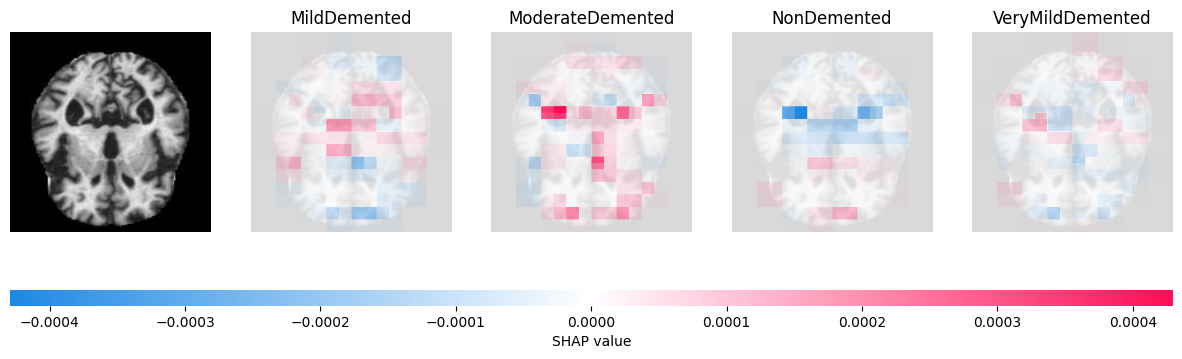

In [ ]:
import shap
import numpy as np

labels = list(os.listdir('new_data/train'))

# Definir la función de predicción para el modelo
def f(x):
    return model_sgd(x)

# Definir la función de máscara de desenfoque
def blur_mask(image, kernel_size=32):
    blurred_image = np.zeros_like(image)
    for i in range(0, image.shape[0], kernel_size):
        for j in range(0, image.shape[1], kernel_size):
            # Obtener el bloque y calcular el promedio
            block = image[i:i+kernel_size, j:j+kernel_size]
            mean_value = block.mean(axis=(0, 1))
            blurred_image[i:i+kernel_size, j:j+kernel_size] = mean_value
    return blurred_image

# Crear la máscara para SHAP
masker_blur = shap.maskers.Image(blur_mask(x_test[0]), x_test[0].shape)

# Configurar el explicador SHAP usando la función de predicción y la máscara personalizada
explainer = shap.Explainer(f, masker_blur, output_names=labels)

# Seleccionar índices de muestra para los que deseas calcular los valores SHAP
indices = [610, 601]

# Generar visualización de valores SHAP para cada muestra seleccionada
for ind in indices:
    print(f"Generando valores SHAP para el índice {ind}...")

    # Calcular los valores SHAP para la muestra actual
    shap_values_ = explainer(x_test[ind:ind+1], max_evals=5000, batch_size=50)
    
    # Visualizar los valores SHAP para cada clase
    shap.image_plot(shap_values_, labels=labels)
